In [12]:
import os

In [13]:
from langchain.vectorstores import Chroma
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain.llms import OpenAI
from langchain.chains import RetrievalQA
from langchain.document_loaders import TextLoader
from langchain.document_loaders import PyPDFLoader
from langchain.document_loaders import PyPDFDirectoryLoader

In [14]:

loader = PyPDFDirectoryLoader(r"C:\Users\Kouts\OneDrive - University of Nicosia\Desktop\Apps4Athens")
pages = loader.load_and_split()

In [15]:
pages

[Document(page_content='ΙΣΟΚΡΑΤΗΣ\n ΤΡΑΠΕΖΑ   ΝΟΜΙΚΩΝ  ΠΛΗΡΟΦΟΡΙΩΝ  ΔΣΑ\nΣΤΟΙΧΕΙΑ ΝΟΜΟΘΕΤΗΜΑ ΤΟΣ\n  \nΕίδος: ΚΩΔΙΚΑΣ ΔΗΜΩΝ ΚΑΙ Κ ΟΙΝΟΤΗΤ ΩΝ\nΈτος: 2006\nΦΕΚ: Α 114 20060608\nΤέθηκε σε ισχύ: 01.01.2007\nΗμ.Υπογραφής: 08.06.2006\n \nΤίτλος\n Κύρωση τ ου Κώδικα Δήμων κ αι Κοινοτήτων.\n \nΣΤΟΙΧΕΙΑ ΑΡΘΡΩΝ  \n  \n \nΑρθρο: 1\nΗμ/νία: 01.01.2007\nΠεριγραφή όρου θησαυρού: ΤΟΠΙΚΗ Α ΥΤΟΔΙΟΙΚΗΣΗ-ΟΡΓ ΑΝΙΣΜΟΙ Τ ΟΠΙΚΗΣ\nΑΥΤΟΔΙΟΙΚΗΣΗΣ\n \nΤίτλος Αρθρου\n Πρώτος Βαθμός της Τ οπικής Αυτ οδιοίκησης\nΚείμενο Αρθρου\n \nΜΕΡΟΣ ΠΡΩΤ Ο\nΔΗΜΟΙ ΚΑΙ Κ ΟΙΝΟΤΗΤΕΣ - ΣΥΣΤ ΑΣΗ ΚΑΙ ΑΡΜΟ ΔΙΟΤΗΤΕΣ\nΚΕΦ ΑΛΑΙΟ Α\nΓΕΝΙΚΗ ΔΙΑ ΤΑΞΗ\n1. Η Τοπική Αυτοδιοίκησ η, ως έκφραση της λαϊκής κυριαρχίας, αποτελεί θεμελιώδη θεσμό του\nδημόσιου βίου των Ελλήνων, όπως αυτός  κατοχυρώνετ αι από τις διατάξεις του άρθρου 102 του\nΣυντάγματ ος και του Ευρω παϊκού Χάρτη Τοπικής Αυτονομίας που κυρώθηκε με το ν. 1850/1989 (ΦΕΚ\n144 Α\').\n2. Οι Δήμοι και οι Κοινότητες συγκρο τούν τους Οργανισμούς του Πρώτου Βαθμού της Τοπικής\nΑυτοδιοίκησης.\n \

In [31]:
text_splitter = RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=50)
texts = text_splitter.split_documents(pages)

In [32]:
print (f'You have {len(texts)} document(s) in your data')
print (f'There are {len(texts[50].page_content)} characters in your sample document')


You have 1221 document(s) in your data
There are 913 characters in your sample document


In [33]:
len(texts)

1221

In [34]:
texts[2000]

IndexError: list index out of range

In [35]:
import tiktoken

tokenizer = tiktoken.get_encoding('cl100k_base')

def tiktoken_len(text):
    tokens = tokenizer.encode(text, disallowed_special=())
    return len(tokens)

In [36]:
tiktoken.encoding_for_model('gpt-3.5-turbo')

<Encoding 'cl100k_base'>

In [37]:
token_counts = [tiktoken_len(doc.page_content) for doc in texts]

In [38]:
print(f"""Min: {min(token_counts)}
Avg: {int(sum(token_counts) / len(token_counts))}
Max: {max(token_counts)}""")

Min: 6
Avg: 709
Max: 1074


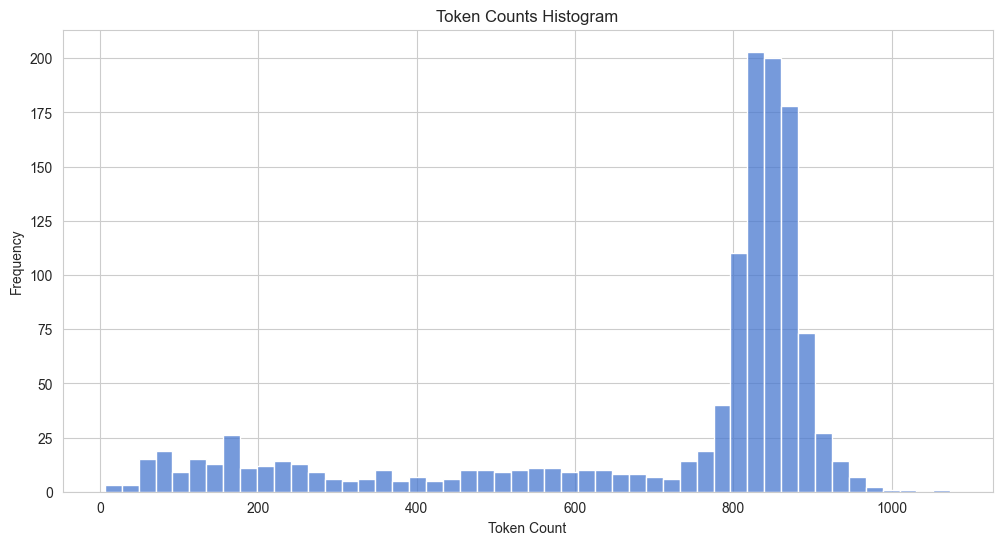

In [39]:
import matplotlib.pyplot as plt
import seaborn as sns

# set style and color palette for the plot
sns.set_style("whitegrid")
sns.set_palette("muted")

# create histogram
plt.figure(figsize=(12, 6))
sns.histplot(token_counts, kde=False, bins=50)

# customize the plot info
plt.title("Token Counts Histogram")
plt.xlabel("Token Count")
plt.ylabel("Frequency")

plt.show()

In [25]:
from langchain_community.embeddings import HuggingFaceEmbeddings
embeddings = HuggingFaceEmbeddings(model_name='lighteternal/stsb-xlm-r-greek-transfer')

c:\Users\Kouts\AppData\Local\Programs\Python\Python39\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [40]:
from langchain.vectorstores import FAISS


db = FAISS.from_documents(texts, embeddings)

In [57]:
query = "Τι κάνω με ραδιενεργά απόβλυτα?"

In [51]:
from langchain.retrievers import BM25Retriever, EnsembleRetriever
bm25_retriever = BM25Retriever.from_documents(texts)
bm25_retriever.k = 4
faiss_retriever = db.as_retriever(search_kwargs={"k":4})
ensemble_retriever = EnsembleRetriever(retrievers=[bm25_retriever, faiss_retriever], weights=[0.5, 0.75])

In [50]:
from langchain import PromptTemplate
prompt_template = """""Θα σου δώσω συγκεκριμένες πληροφορίες [ΠΛΗΡΟΦΟΡΙΕΣ] και μια 
                        ερώτηση [ΕΡΩΤΗΣΗ]. Βάσει αυτών, θέλω μια αναλυτική και ακριβή απάντηση [ΑΠΑΝΤΗΣΗ]. Απαντάς σε έναν απλό πολίτη σαν εκπρόσωπος του Δήμου του. Εάν δεν διαθέτεις 
                        αρκετές πληροφορίες για μια συγκεκριμένη απάντηση, χρησιμοποίησε τη φράση: 'Δυστυχώς δεν έχω τις απαραίτητες 
                        πληροφορίες για να σου προσφέρω μια αξιόπιστη απάντηση. ' 
                        ΠΛΗΡΟΦΟΡΙΕΣ: \n{context}\n
                        ΕΡΩΤΗΣΗ: \n{question}\n
                        ΑΠΑΝΤΗΣΗ:"
                        """

prompt = PromptTemplate(template=prompt_template, input_variables=["context", "question"])

In [58]:
from langchain.chat_models import ChatOpenAI
from langchain.chains import RetrievalQA

llm = ChatOpenAI(temperature=0.5, model='gpt-4')
chain = RetrievalQA.from_chain_type(llm=llm, chain_type="stuff", retriever=ensemble_retriever,chain_type_kwargs={"prompt" : prompt, "verbose": True}) 


result = chain.run(query)
print(result)



> Entering new StuffDocumentsChain chain...


> Entering new LLMChain chain...
Prompt after formatting:
""Θα σου δώσω συγκεκριμένες πληροφορίες [ΠΛΗΡΟΦΟΡΙΕΣ] και μια 
                        ερώτηση [ΕΡΩΤΗΣΗ]. Βάσει αυτών, θέλω μια αναλυτική και ακριβή απάντηση [ΑΠΑΝΤΗΣΗ]. Εάν δεν διαθέτεις 
                        αρκετές πληροφορίες για μια συγκεκριμένη απάντηση, χρησιμοποίησε τη φράση: 'Δυστυχώς δεν έχω τις απαραίτητες 
                        πληροφορίες για να σου προσφέρω μια αξιόπιστη απάντηση. ' 
                        ΠΛΗΡΟΦΟΡΙΕΣ: 
εγκατάστασης.         
 
3. Στις εγκαταστάσε ις ή  χώρους  προσωρινής αποθήκευσης ΡΑ τα ραδιενεργά απόβλητα  
παραμ ένουν για ένα χρονικό διάστημα  σύμφωνα με τους όρους της άδειας , με σκοπό είτε την

εξαιρουμένης της μεταφοράς εκτός εγκατάστασης,  
11. «διαχε ίριση ραδιενεργών αποβλήτων» : Ό λες οι δραστηρ ιότητες που σχετίζονται με το 
χειρισμό, την προεπεξεργασία, την επεξεργασία, την προετοιμασία, την αποθήκευση ή τη 
διάθεση ραδιενεργών απο